<h1>ACDC Main Demo</h1>

<p>This notebook (which doubles as a script) shows several use cases of ACDC</p>

<p>The codebase is built on top of https://github.com/neelnanda-io/TransformerLens (source version)</p>

<h3>Setup:</h3>
<p>Janky code to do different setup when run in a Colab notebook vs VSCode (adapted from e.g <a href="https://github.com/neelnanda-io/TransformerLens/blob/5c89b7583e73ce96db5e46ef86a14b15f303dde6/demos/Activation_Patching_in_TL_Demo.ipynb">this notebook</a>)</p>

In [1]:
try:
    import google.colab

    IN_COLAB = True
    print("Running as a Colab notebook")

    import subprocess # to install graphviz dependencies
    command = ['apt-get', 'install', 'graphviz-dev']
    subprocess.run(command, check=True)

    import os # make images folder
    os.mkdir("ims/")

    from IPython import get_ipython
    ipython = get_ipython()

    ipython.run_line_magic( # install ACDC
        "pip",
        "install git+https://github.com/ArthurConmy/Automatic-Circuit-Discovery.git@d89f7fa9cbd095202f3940c889cb7c6bf5a9b516",
    )

except Exception as e:
    IN_COLAB = False
    print("Running outside of colab")

    import numpy # crucial to not get cursed error
    import plotly

    plotly.io.renderers.default = "colab"  # added by Arthur so running as a .py notebook with #%% generates .ipynb notebooks that display in colab
    # disable this option when developing rather than generating notebook outputs

    import os # make images folder
    if not os.path.exists("ims/"):
        os.mkdir("ims/")

    from IPython import get_ipython

    ipython = get_ipython()
    if ipython is not None:
        print("Running as a notebook")
        ipython.run_line_magic("load_ext", "autoreload")  # type: ignore
        ipython.run_line_magic("autoreload", "2")  # type: ignore
    else:
        print("Running as a script")

Running outside of colab
Running as a notebook


<h2>Imports etc</h2>

In [2]:
import wandb
import IPython
from IPython.display import Image, display
import torch
import gc
from tqdm import tqdm
import networkx as nx
import os
import torch
import huggingface_hub
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
from tqdm import tqdm
import yaml
from transformers import AutoModelForCausalLM, AutoConfig, AutoTokenizer

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from transformer_lens.hook_points import HookedRootModule, HookPoint
from transformer_lens.HookedTransformer import (
    HookedTransformer,
)
try:
    from acdc.tracr_task.utils import (
        get_all_tracr_things,
        get_tracr_model_input_and_tl_model,
    )
except Exception as e:
    print(f"Could not import `tracr` because {e}; the rest of the file should work but you cannot use the tracr tasks")
from acdc.docstring.utils import get_all_docstring_things
from acdc.acdc_utils import (
    make_nd_dict,
    reset_network,
    shuffle_tensor,
    cleanup,
    ct,
    TorchIndex,
    Edge,
    EdgeType,
)  # these introduce several important classes !!!

from acdc.TLACDCCorrespondence import TLACDCCorrespondence
from acdc.TLACDCInterpNode import TLACDCInterpNode
from acdc.TLACDCExperiment import TLACDCExperiment

from acdc.acdc_utils import (
    kl_divergence,
)
from acdc.ioi.utils import (
    get_all_ioi_things,
    get_gpt2_small,
)
from acdc.induction.utils import (
    get_all_induction_things,
    get_validation_data,
    get_good_induction_candidates,
    get_mask_repeat_candidates,
)
from acdc.greaterthan.utils import get_all_greaterthan_things
from acdc.acdc_graphics import (
    build_colorscheme,
    show,
)
import argparse

torch.autograd.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<h2>ACDC Experiment Setup</h2>
<p>We use a `parser to set all the options for the ACDC experiment.
This is still usable in notebooks! We can pass a string to the parser, see below.
We'll reproduce </p>

In [3]:
parser = argparse.ArgumentParser(description="Used to launch ACDC runs. Only task and threshold are required")

task_choices = ['ioi', 'docstring', 'induction', 'tracr-reverse', 'tracr-proportion', 'greaterthan']
parser.add_argument('--task', type=str, required=True, choices=task_choices, help=f'Choose a task from the available options: {task_choices}')
parser.add_argument('--threshold', type=float, required=True, help='Value for THRESHOLD')
parser.add_argument('--first-cache-cpu', type=str, required=False, default="True", help='Value for FIRST_CACHE_CPU (the old name for the `online_cache`)')
parser.add_argument('--second-cache-cpu', type=str, required=False, default="True", help='Value for SECOND_CACHE_CPU (the old name for the `corrupted_cache`)')
parser.add_argument('--zero-ablation', action='store_true', help='Use zero ablation')
parser.add_argument('--using-wandb', action='store_true', help='Use wandb')
parser.add_argument('--wandb-entity-name', type=str, required=False, default="remix_school-of-rock", help='Value for WANDB_ENTITY_NAME')
parser.add_argument('--wandb-group-name', type=str, required=False, default="default", help='Value for WANDB_GROUP_NAME')
parser.add_argument('--wandb-project-name', type=str, required=False, default="acdc", help='Value for WANDB_PROJECT_NAME')
parser.add_argument('--wandb-run-name', type=str, required=False, default=None, help='Value for WANDB_RUN_NAME')
parser.add_argument("--wandb-dir", type=str, default="/tmp/wandb")
parser.add_argument("--wandb-mode", type=str, default="online")
parser.add_argument('--indices-mode', type=str, default="normal")
parser.add_argument('--names-mode', type=str, default="normal")
parser.add_argument('--device', type=str, default="cuda")
parser.add_argument('--reset-network', type=int, default=0, help="Whether to reset the network we're operating on before running interp on it")
parser.add_argument('--metric', type=str, default="kl_div", help="Which metric to use for the experiment")
parser.add_argument('--torch-num-threads', type=int, default=0, help="How many threads to use for torch (0=all)")
parser.add_argument('--seed', type=int, default=1234)
parser.add_argument("--max-num-epochs",type=int, default=100_000)
parser.add_argument('--single-step', action='store_true', help='Use single step, mostly for testing')
parser.add_argument("--abs-value-threshold", action='store_true', help='Use the absolute value of the result to check threshold')

if ipython is not None:
    # We are in a notebook
    # you can put the command you would like to run as the ... in r"""..."""
    args = parser.parse_args(
        [line.strip() for line in r"""--task=ioi\
--threshold=0.05\
--first-cache-cpu=False\
--second-cache-cpu=False\
--max-num-epochs=100000""".split("\\\n")]
    )
else:
    # read from command line
    args = parser.parse_args()

# Process args

if args.torch_num_threads > 0:
    torch.set_num_threads(args.torch_num_threads)
torch.manual_seed(args.seed)

TASK = args.task
if args.first_cache_cpu is None: # manage default
    ONLINE_CACHE_CPU = True
elif args.first_cache_cpu.lower() == "false":
    ONLINE_CACHE_CPU = False
elif args.first_cache_cpu.lower() == "true":
    ONLINE_CACHE_CPU = True
else: 
    raise ValueError(f"first_cache_cpu must be either True or False, got {args.first_cache_cpu}")
if args.second_cache_cpu is None:
    CORRUPTED_CACHE_CPU = True
elif args.second_cache_cpu.lower() == "false":
    CORRUPTED_CACHE_CPU = False
elif args.second_cache_cpu.lower() == "true":
    CORRUPTED_CACHE_CPU = True
else:
    raise ValueError(f"second_cache_cpu must be either True or False, got {args.second_cache_cpu}")
THRESHOLD = args.threshold  # only used if >= 0.0
ZERO_ABLATION = True if args.zero_ablation else False
USING_WANDB = True if args.using_wandb else False
WANDB_ENTITY_NAME = args.wandb_entity_name
WANDB_PROJECT_NAME = args.wandb_project_name
WANDB_RUN_NAME = args.wandb_run_name
WANDB_GROUP_NAME = args.wandb_group_name
INDICES_MODE = args.indices_mode
NAMES_MODE = args.names_mode
DEVICE = args.device
RESET_NETWORK = args.reset_network
SINGLE_STEP = True if args.single_step else False

<h2>Setup Task</h2>

In [4]:

second_metric = None  # some tasks only have one metric
use_pos_embed = TASK.startswith("tracr")

if TASK == "ioi":
    num_examples = 100
    things = get_all_ioi_things(
        num_examples=num_examples, device=DEVICE, metric_name=args.metric
    )
elif TASK == "tracr-reverse":
    num_examples = 6
    things = get_all_tracr_things(
        task="reverse",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "tracr-proportion":
    num_examples = 50
    things = get_all_tracr_things(
        task="proportion",
        metric_name=args.metric,
        num_examples=num_examples,
        device=DEVICE,
    )
elif TASK == "induction":
    num_examples = 10
    seq_len = 300
    things = get_all_induction_things(
        num_examples=num_examples, seq_len=seq_len, device=DEVICE, metric=args.metric
    )
elif TASK == "docstring":
    num_examples = 50
    seq_len = 41
    things = get_all_docstring_things(
        num_examples=num_examples,
        seq_len=seq_len,
        device=DEVICE,
        metric_name=args.metric,
        correct_incorrect_wandb=True,
    )
elif TASK == "greaterthan":
    num_examples = 100
    things = get_all_greaterthan_things(
        num_examples=num_examples, metric_name=args.metric, device=DEVICE
    )
else:
    raise ValueError(f"Unknown task {TASK}")

Loaded pretrained model EleutherAI/pythia-70m-deduped into HookedTransformer
Moving model to device:  cuda


/workspace/Automatic-Circuit-Discovery/acdc/ioi/ioi_dataset.py:514: UserWarning:

S2 index has been computed as the same for S and S2



Then, Alexander and Michelle went to the restaurant. Michelle gave a bone to Alexander
Tokenized text with corresponding tokens:
Token 0: 0 - '<|endoftext|>'
Token 1: 5872 - 'Then'
Token 2: 13 - ','
Token 3: 13651 - ' Alexander'
Token 4: 285 - ' and'
Token 5: 28331 - ' Michelle'
Token 6: 2427 - ' went'
Token 7: 281 - ' to'
Token 8: 253 - ' the'
Token 9: 10301 - ' restaurant'
Token 10: 15 - '.'
Token 11: 28331 - ' Michelle'
Token 12: 3534 - ' gave'
Token 13: 247 - ' a'
Token 14: 5961 - ' bone'
Token 15: 281 - ' to'
Token 16: 13651 - ' Alexander'
tensor([ 5872,    13, 13651,   285, 28331,  2427,   281,   253, 10301,    15,
        28331,  3534,   247,  5961,   281], device='cuda:0')


<p> Let's define the four most important objects for ACDC experiments:

In [5]:

validation_metric = things.validation_metric # metric we use (e.g KL divergence)
toks_int_values = things.validation_data # clean data x_i
toks_int_values_other = things.validation_patch_data # corrupted data x_i'
tl_model = things.tl_model # transformerlens model

if RESET_NETWORK:
    reset_network(TASK, DEVICE, tl_model)

<h2>Setup ACDC Experiment</h2>

In [6]:
# Make notes for potential wandb run
try:
    with open(__file__, "r") as f:
        notes = f.read()
except:
    notes = "No notes generated, expected when running in an .ipynb file"

tl_model.reset_hooks()

# Save some mem
gc.collect()
torch.cuda.empty_cache()

# Setup wandb if needed
if WANDB_RUN_NAME is None or IPython.get_ipython() is not None:
    WANDB_RUN_NAME = f"{ct()}{'_randomindices' if INDICES_MODE=='random' else ''}_{THRESHOLD}{'_zero' if ZERO_ABLATION else ''}"
else:
    assert WANDB_RUN_NAME is not None, "I want named runs, always"

tl_model.reset_hooks()
exp = TLACDCExperiment(
    model=tl_model,
    threshold=THRESHOLD,
    using_wandb=USING_WANDB,
    wandb_entity_name=WANDB_ENTITY_NAME,
    wandb_project_name=WANDB_PROJECT_NAME,
    wandb_run_name=WANDB_RUN_NAME,
    wandb_group_name=WANDB_GROUP_NAME,
    wandb_notes=notes,
    wandb_dir=args.wandb_dir,
    wandb_mode=args.wandb_mode,
    wandb_config=args,
    zero_ablation=ZERO_ABLATION,
    abs_value_threshold=args.abs_value_threshold,
    ds=toks_int_values,
    ref_ds=toks_int_values_other,
    metric=validation_metric,
    second_metric=second_metric,
    verbose=True,
    indices_mode=INDICES_MODE,
    names_mode=NAMES_MODE,
    corrupted_cache_cpu=CORRUPTED_CACHE_CPU,
    hook_verbose=False,
    online_cache_cpu=ONLINE_CACHE_CPU,
    add_sender_hooks=True,
    use_pos_embed=use_pos_embed,
    add_receiver_hooks=False,
    remove_redundant=False,
    show_full_index=use_pos_embed,
)

dict_keys(['blocks.5.hook_resid_post', 'blocks.5.hook_mlp_out', 'blocks.5.hook_mlp_in', 'blocks.5.attn.hook_result', 'blocks.5.attn.hook_q', 'blocks.5.hook_q_input', 'blocks.5.attn.hook_k', 'blocks.5.hook_k_input', 'blocks.5.attn.hook_v', 'blocks.5.hook_v_input', 'blocks.4.hook_mlp_out', 'blocks.4.hook_mlp_in', 'blocks.4.attn.hook_result', 'blocks.4.attn.hook_q', 'blocks.4.hook_q_input', 'blocks.4.attn.hook_k', 'blocks.4.hook_k_input', 'blocks.4.attn.hook_v', 'blocks.4.hook_v_input', 'blocks.3.hook_mlp_out', 'blocks.3.hook_mlp_in', 'blocks.3.attn.hook_result', 'blocks.3.attn.hook_q', 'blocks.3.hook_q_input', 'blocks.3.attn.hook_k', 'blocks.3.hook_k_input', 'blocks.3.attn.hook_v', 'blocks.3.hook_v_input', 'blocks.2.hook_mlp_out', 'blocks.2.hook_mlp_in', 'blocks.2.attn.hook_result', 'blocks.2.attn.hook_q', 'blocks.2.hook_q_input', 'blocks.2.attn.hook_k', 'blocks.2.hook_k_input', 'blocks.2.attn.hook_v', 'blocks.2.hook_v_input', 'blocks.1.hook_mlp_out', 'blocks.1.hook_mlp_in', 'blocks.1.at

<h2>Run steps of ACDC: iterate over a NODE in the model's computational graph</h2>
<p>WARNING! This will take a few minutes to run, but there should be rolling nice pictures too : )</p>

No edge 3772
New metric: 1.216096308098713e-07

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.5.hook_resid_post, [:]))

Metric after removing connection to blocks.5.hook_mlp_out [:] is 0.252573698759079 (and current metric 1.216096308098713e-07)
Result is 0.25257357714944817...so keeping connection
No edge 3772

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.5.hook_resid_post, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 7] is 0.004095680546015501 (and current metric 1.5253270646553574e-07)
Result is 0.0040955280133090355...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.5.hook_resid_post, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 6] is 0.01219873409718275 (and current metric 0.004095680546015501)
Result is 

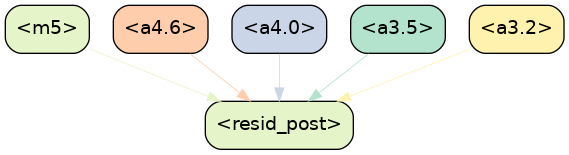

0 --------------------------------------------------
No edge 3722
3722
No edge 3722
New metric: 0.17822735011577606
No edge 3722
We moved to  blocks.5.hook_mlp_in[:]
No edge 3722


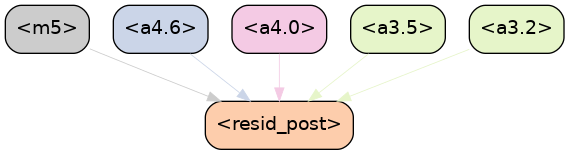

1 --------------------------------------------------
No edge 3722
3722
No edge 3722
New metric: 0.17822735011577606

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.5.hook_mlp_in, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 7] is 0.2526130974292755 (and current metric 0.17822735011577606)
Result is 0.07438574731349945...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.5.hook_mlp_in, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 6] is 0.25651127099990845 (and current metric 0.17822735011577606)
Result is 0.07828392088413239...so keeping connection

Node: cur_parent=TLACDCInterpNode(blocks.5.attn.hook_result, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.5.hook_mlp_in, [:]))

Metric after removing connection to blocks.5.attn.hook_result [:, :, 5] is 0.26504069566726

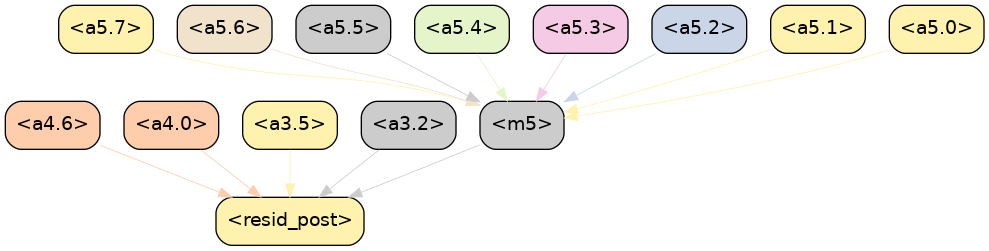

2 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 6]
No edge 3676


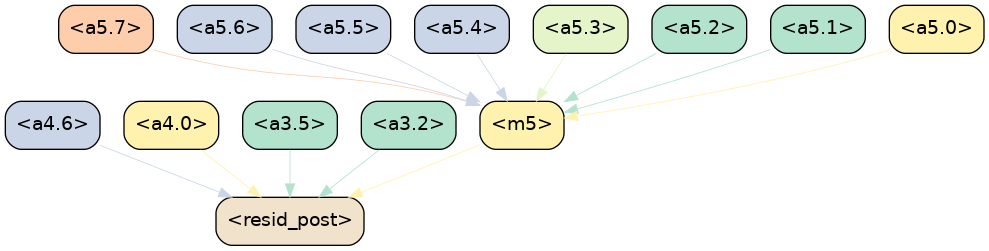

3 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 5]
No edge 3676


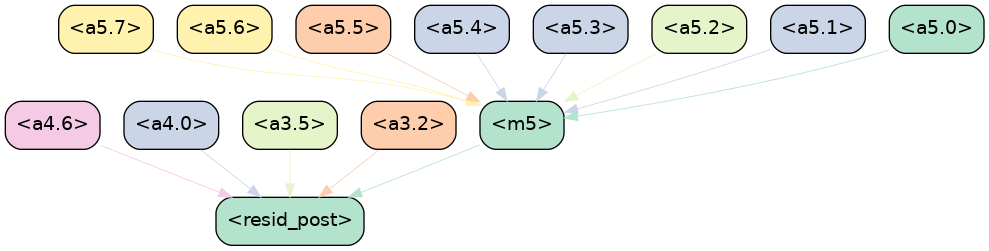

4 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 4]
No edge 3676


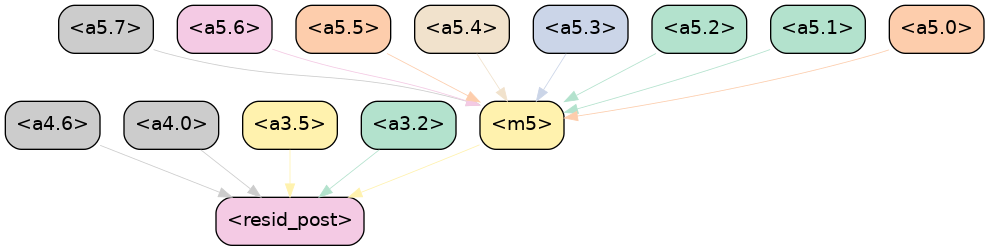

5 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 3]
No edge 3676


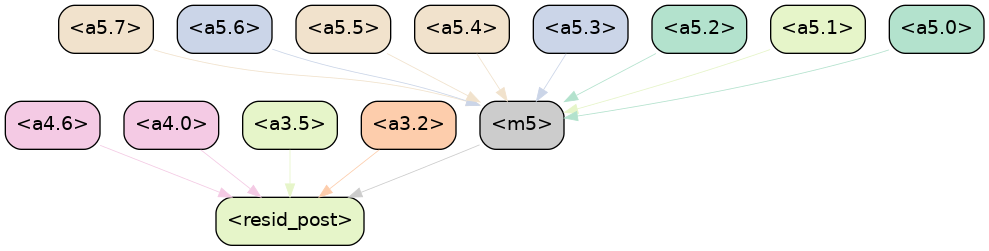

6 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 2]
No edge 3676


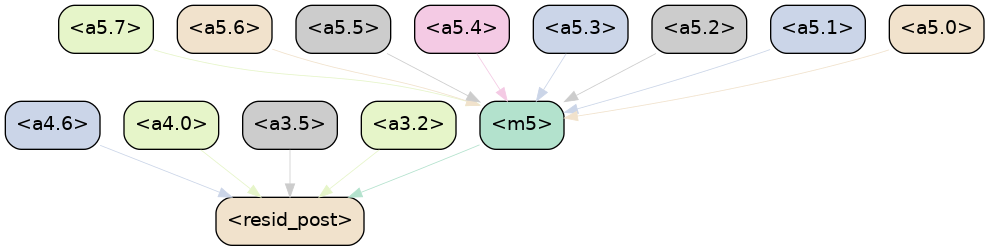

7 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 1]
No edge 3676


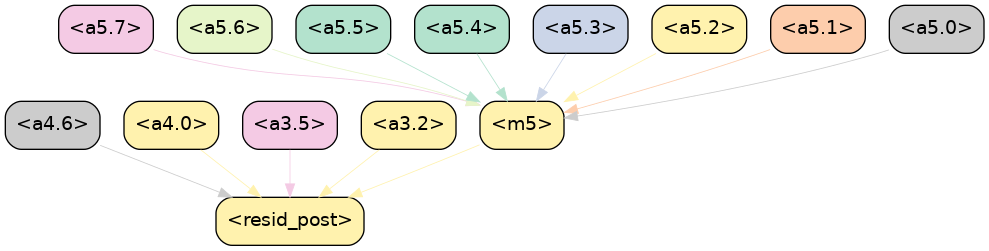

8 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_result[:, :, 0]
No edge 3676


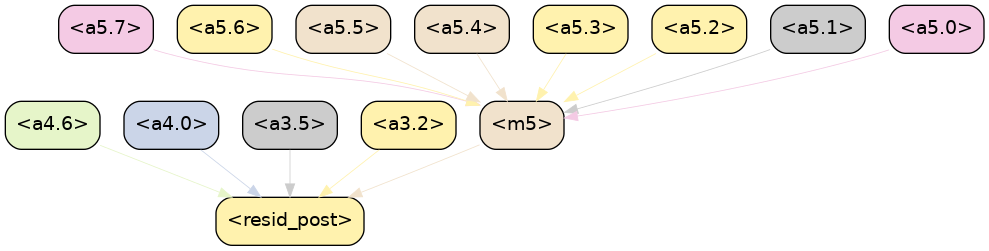

9 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418
No edge 3676
No edge 3676
No edge 3676
We moved to  blocks.5.attn.hook_v[:, :, 7]
No edge 3676


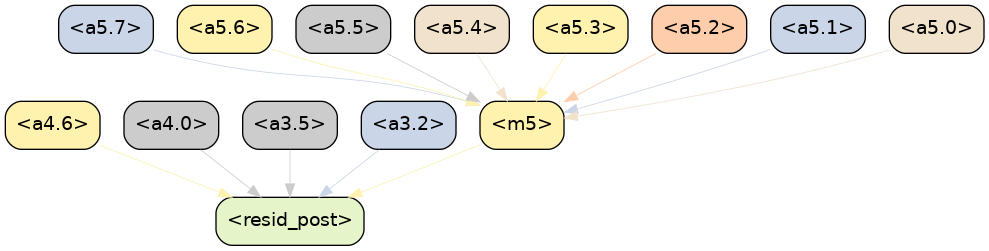

10 --------------------------------------------------
No edge 3676
3676
No edge 3676
New metric: 0.21495376527309418

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 7]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 7] is 0.21672718226909637 (and current metric 0.21495376527309418)
Result is 0.0017734169960021973...so removing connection
No edge 3675
We moved to  blocks.5.attn.hook_v[:, :, 6]
No edge 3675


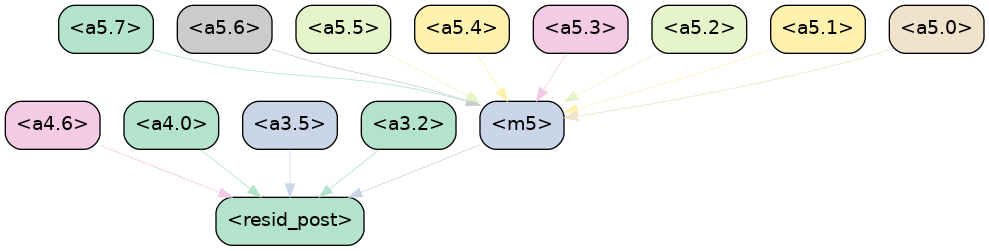

11 --------------------------------------------------
No edge 3675
3675
No edge 3675
New metric: 0.21672718226909637

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 6]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 6] is 0.2200685441493988 (and current metric 0.21672718226909637)
Result is 0.003341361880302429...so removing connection
No edge 3674
We moved to  blocks.5.attn.hook_v[:, :, 5]
No edge 3674


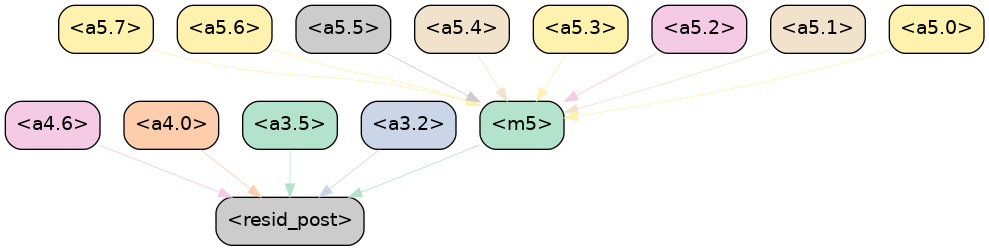

12 --------------------------------------------------
No edge 3674
3674
No edge 3674
New metric: 0.2200685441493988

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 5]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 5] is 0.20747116208076477 (and current metric 0.2200685441493988)
Result is -0.012597382068634033...so removing connection
No edge 3673
We moved to  blocks.5.attn.hook_v[:, :, 4]
No edge 3673


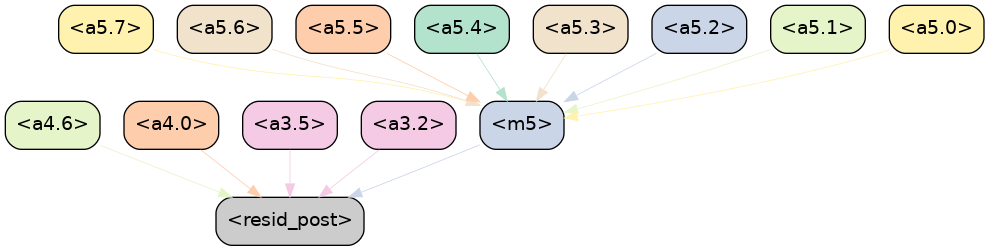

13 --------------------------------------------------
No edge 3673
3673
No edge 3673
New metric: 0.20747116208076477

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 4]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 4]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 4] is 0.2100755274295807 (and current metric 0.20747116208076477)
Result is 0.002604365348815918...so removing connection
No edge 3672
We moved to  blocks.5.attn.hook_v[:, :, 3]
No edge 3672


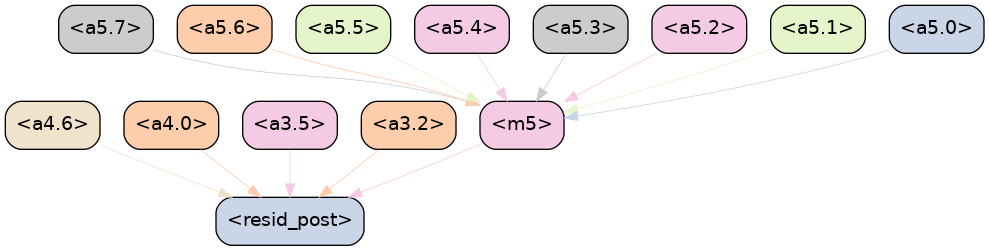

14 --------------------------------------------------
No edge 3672
3672
No edge 3672
New metric: 0.2100755274295807

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 3]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 3] is 0.20930300652980804 (and current metric 0.2100755274295807)
Result is -0.000772520899772644...so removing connection
No edge 3671
We moved to  blocks.5.attn.hook_v[:, :, 2]
No edge 3671


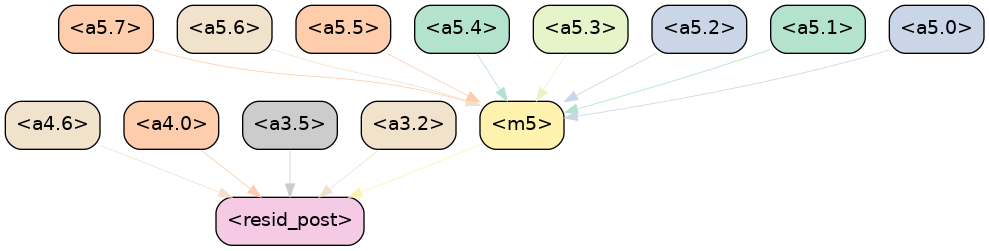

15 --------------------------------------------------
No edge 3671
3671
No edge 3671
New metric: 0.20930300652980804

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 2]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 2] is 0.2108794003725052 (and current metric 0.20930300652980804)
Result is 0.0015763938426971436...so removing connection
No edge 3670
We moved to  blocks.5.attn.hook_v[:, :, 1]
No edge 3670


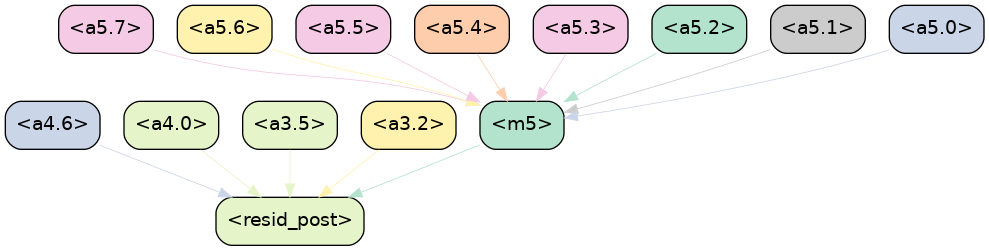

16 --------------------------------------------------
No edge 3670
3670
No edge 3670
New metric: 0.2108794003725052

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 1]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 1] is 0.22072196006774902 (and current metric 0.2108794003725052)
Result is 0.009842559695243835...so removing connection
No edge 3669
We moved to  blocks.5.attn.hook_v[:, :, 0]
No edge 3669


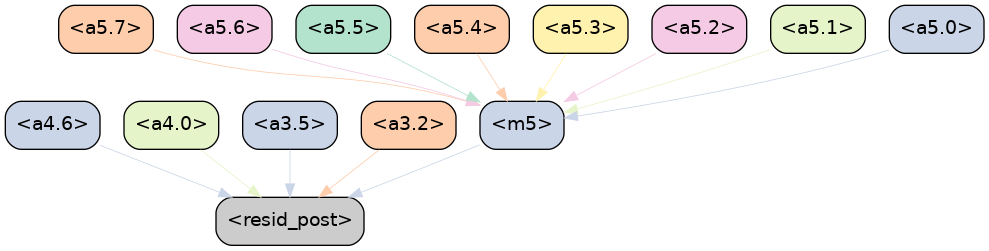

17 --------------------------------------------------
No edge 3669
3669
No edge 3669
New metric: 0.22072196006774902

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.5.hook_v_input [:, :, 0] is 0.22156590223312378 (and current metric 0.22072196006774902)
Result is 0.0008439421653747559...so removing connection
No edge 3668
We moved to  blocks.5.attn.hook_k[:, :, 7]
No edge 3668


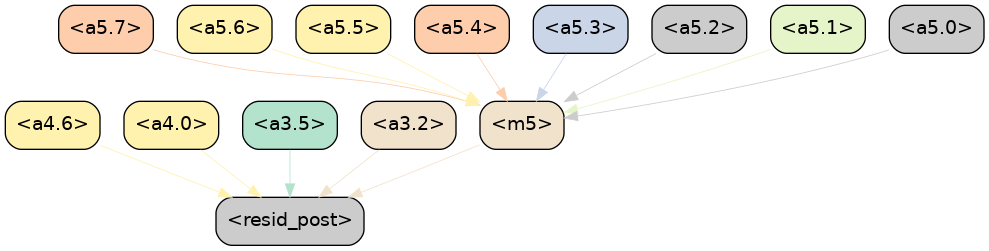

18 --------------------------------------------------
No edge 3668
3668
No edge 3668
New metric: 0.22156590223312378

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 7]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 7] is 0.22155547142028809 (and current metric 0.22156590223312378)
Result is -1.043081283569336e-05...so removing connection
No edge 3667
We moved to  blocks.5.attn.hook_k[:, :, 6]
No edge 3667


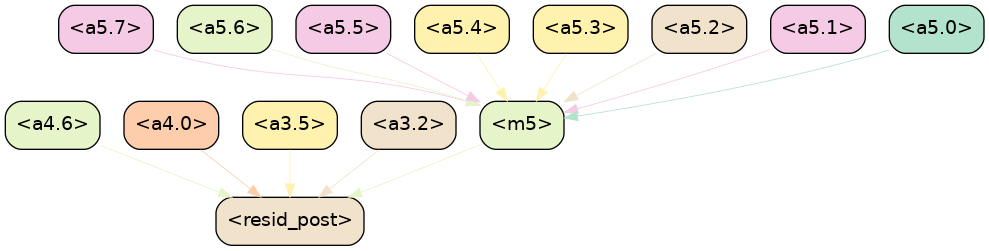

19 --------------------------------------------------
No edge 3667
3667
No edge 3667
New metric: 0.22155547142028809

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 6]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 6] is 0.21345704793930054 (and current metric 0.22155547142028809)
Result is -0.008098423480987549...so removing connection
No edge 3666
We moved to  blocks.5.attn.hook_k[:, :, 5]
No edge 3666


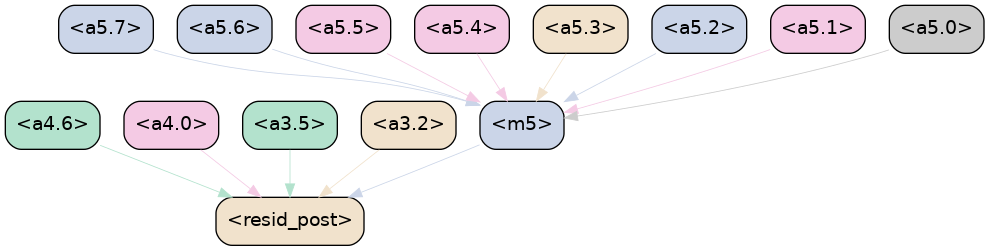

20 --------------------------------------------------
No edge 3666
3666
No edge 3666
New metric: 0.21345704793930054

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 5]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 5] is 0.20638343691825867 (and current metric 0.21345704793930054)
Result is -0.00707361102104187...so removing connection
No edge 3665
We moved to  blocks.5.attn.hook_k[:, :, 4]
No edge 3665


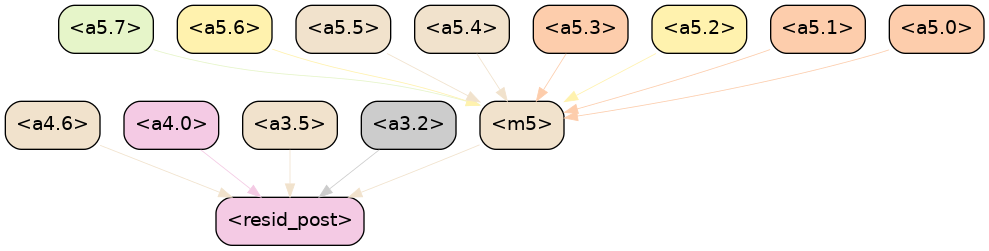

21 --------------------------------------------------
No edge 3665
3665
No edge 3665
New metric: 0.20638343691825867

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 4]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 4]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 4] is 0.20697733759880066 (and current metric 0.20638343691825867)
Result is 0.0005939006805419922...so removing connection
No edge 3664
We moved to  blocks.5.attn.hook_k[:, :, 3]
No edge 3664


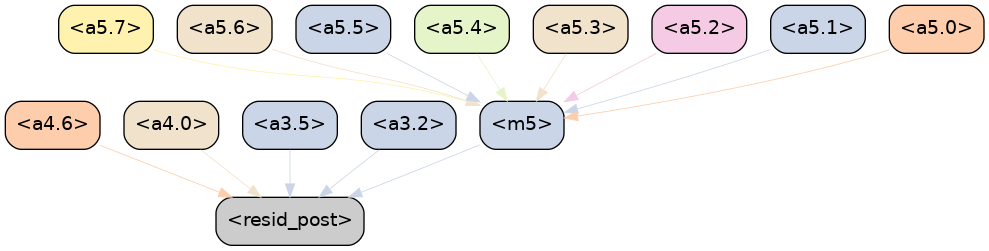

22 --------------------------------------------------
No edge 3664
3664
No edge 3664
New metric: 0.20697733759880066

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 3]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 3] is 0.20667853951454163 (and current metric 0.20697733759880066)
Result is -0.0002987980842590332...so removing connection
No edge 3663
We moved to  blocks.5.attn.hook_k[:, :, 2]
No edge 3663


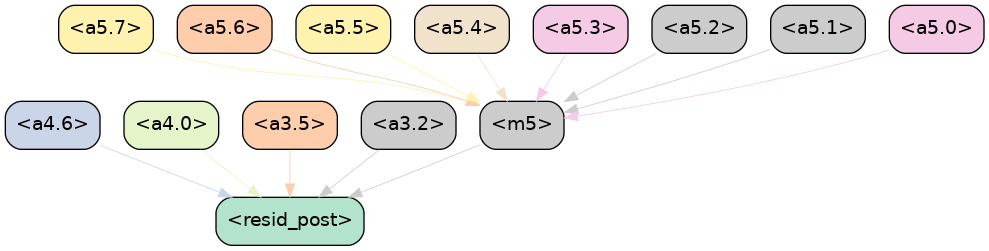

23 --------------------------------------------------
No edge 3663
3663
No edge 3663
New metric: 0.20667853951454163

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 2]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 2] is 0.20528438687324524 (and current metric 0.20667853951454163)
Result is -0.0013941526412963867...so removing connection
No edge 3662
We moved to  blocks.5.attn.hook_k[:, :, 1]
No edge 3662


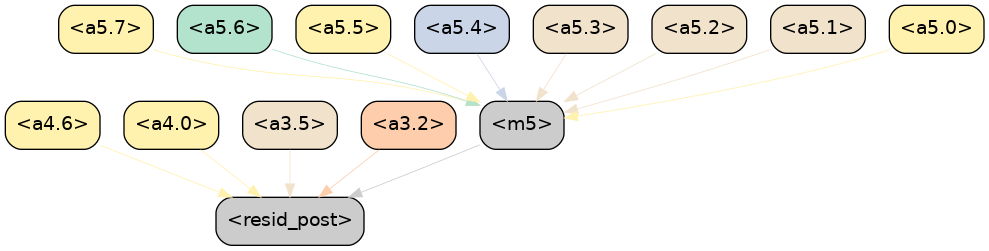

24 --------------------------------------------------
No edge 3662
3662
No edge 3662
New metric: 0.20528438687324524

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 1]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 1] is 0.20196634531021118 (and current metric 0.20528438687324524)
Result is -0.0033180415630340576...so removing connection
No edge 3661
We moved to  blocks.5.attn.hook_k[:, :, 0]
No edge 3661


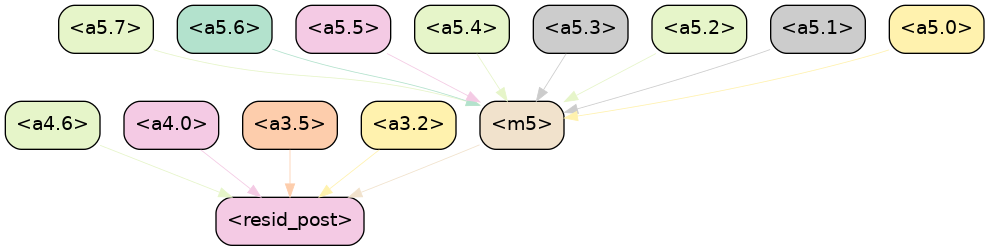

25 --------------------------------------------------
No edge 3661
3661
No edge 3661
New metric: 0.20196634531021118

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.5.hook_k_input [:, :, 0] is 0.20099681615829468 (and current metric 0.20196634531021118)
Result is -0.0009695291519165039...so removing connection
No edge 3660
We moved to  blocks.5.attn.hook_q[:, :, 7]
No edge 3660


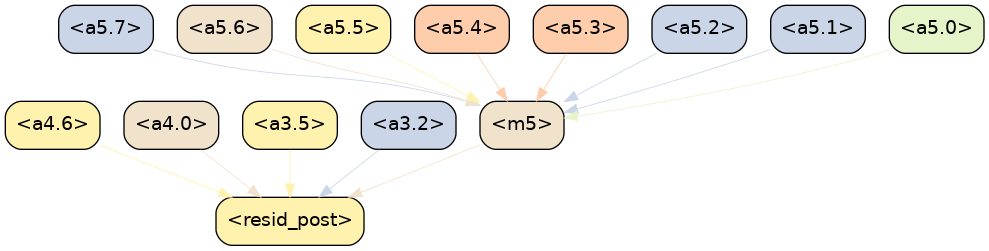

26 --------------------------------------------------
No edge 3660
3660
No edge 3660
New metric: 0.20099681615829468

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 7]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 7] is 0.2011231631040573 (and current metric 0.20099681615829468)
Result is 0.00012634694576263428...so removing connection
No edge 3659
We moved to  blocks.5.attn.hook_q[:, :, 6]
No edge 3659


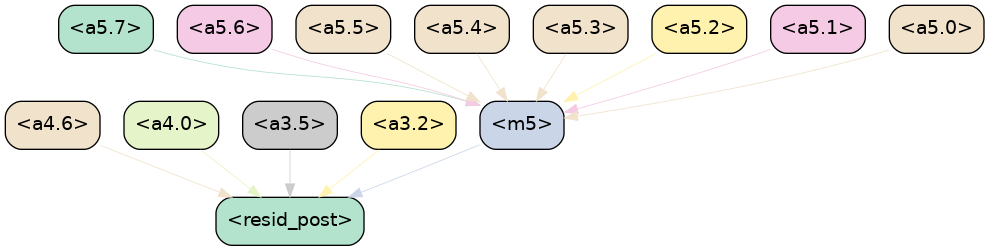

27 --------------------------------------------------
No edge 3659
3659
No edge 3659
New metric: 0.2011231631040573

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 6]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 6] is 0.19843068718910217 (and current metric 0.2011231631040573)
Result is -0.002692475914955139...so removing connection
No edge 3658
We moved to  blocks.5.attn.hook_q[:, :, 5]
No edge 3658


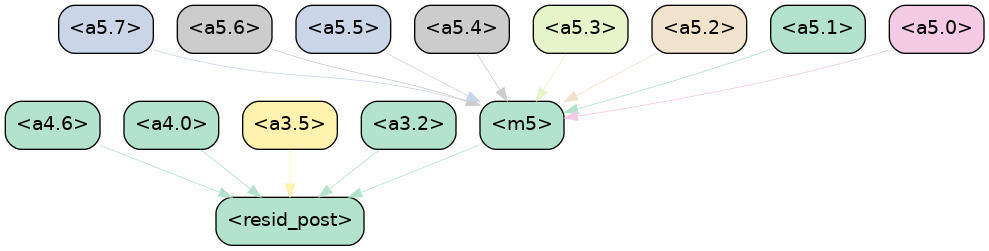

28 --------------------------------------------------
No edge 3658
3658
No edge 3658
New metric: 0.19843068718910217

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 5]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 5] is 0.19327349960803986 (and current metric 0.19843068718910217)
Result is -0.005157187581062317...so removing connection
No edge 3657
We moved to  blocks.5.attn.hook_q[:, :, 4]
No edge 3657


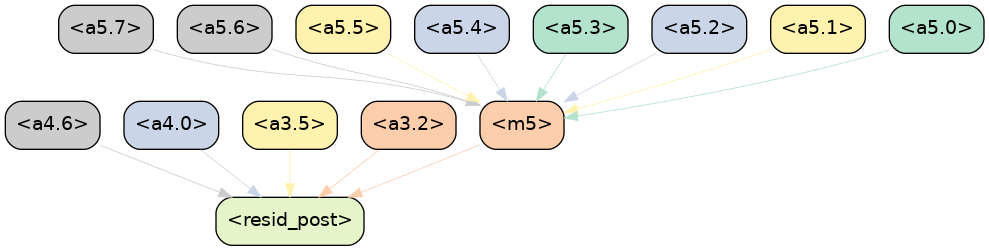

29 --------------------------------------------------
No edge 3657
3657
No edge 3657
New metric: 0.19327349960803986

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 4]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 4]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 4] is 0.18884876370429993 (and current metric 0.19327349960803986)
Result is -0.004424735903739929...so removing connection
No edge 3656
We moved to  blocks.5.attn.hook_q[:, :, 3]
No edge 3656


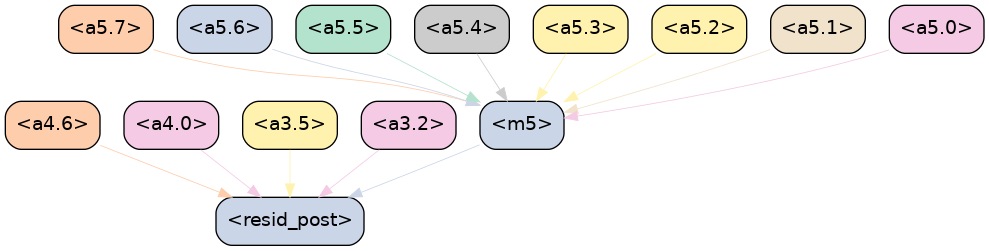

30 --------------------------------------------------
No edge 3656
3656
No edge 3656
New metric: 0.18884876370429993

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 3]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 3]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 3] is 0.1881878823041916 (and current metric 0.18884876370429993)
Result is -0.0006608814001083374...so removing connection
No edge 3655
We moved to  blocks.5.attn.hook_q[:, :, 2]
No edge 3655


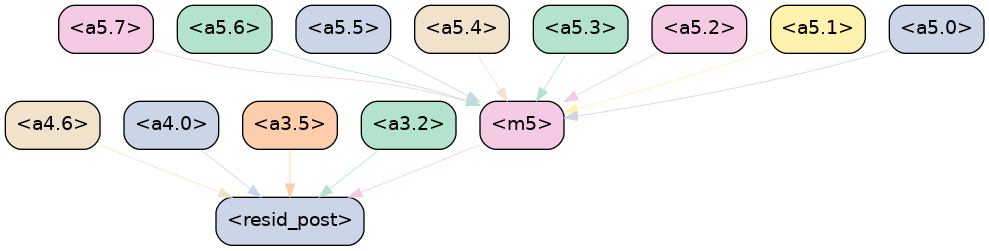

31 --------------------------------------------------
No edge 3655
3655
No edge 3655
New metric: 0.1881878823041916

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 2]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 2] is 0.18759822845458984 (and current metric 0.1881878823041916)
Result is -0.0005896538496017456...so removing connection
No edge 3654
We moved to  blocks.5.attn.hook_q[:, :, 1]
No edge 3654


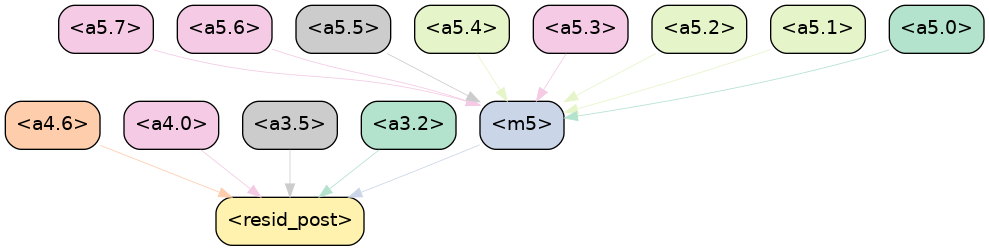

32 --------------------------------------------------
No edge 3654
3654
No edge 3654
New metric: 0.18759822845458984

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 1]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 1]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 1] is 0.1871546059846878 (and current metric 0.18759822845458984)
Result is -0.0004436224699020386...so removing connection
No edge 3653
We moved to  blocks.5.attn.hook_q[:, :, 0]
No edge 3653


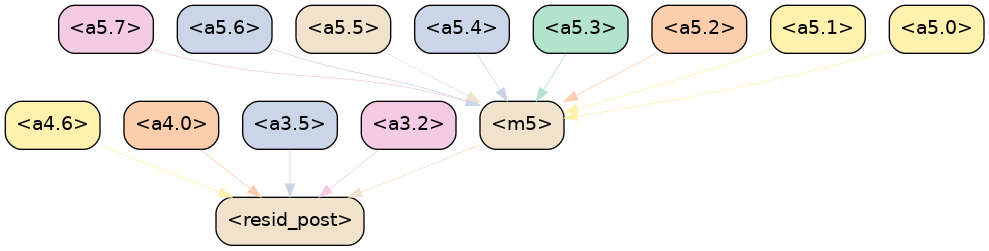

33 --------------------------------------------------
No edge 3653
3653
No edge 3653
New metric: 0.1871546059846878

Node: cur_parent=TLACDCInterpNode(blocks.5.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.5.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.5.hook_q_input [:, :, 0] is 0.18705061078071594 (and current metric 0.1871546059846878)
Result is -0.00010399520397186279...so removing connection
No edge 3652
We moved to  blocks.5.hook_v_input[:, :, 7]
No edge 3652
No edge 3606
But it's bad
We moved to  blocks.5.hook_v_input[:, :, 6]
No edge 3606
No edge 3560
But it's bad
We moved to  blocks.5.hook_v_input[:, :, 5]
No edge 3560
No edge 3514
But it's bad
We moved to  blocks.5.hook_v_input[:, :, 4]
No edge 3514
No edge 3468
But it's bad
We moved to  blocks.5.hook_v_input[:, :, 3]
No edge 3468
No edge 3422
But it's bad
We moved to  blocks.5.hook_v_input[:, :, 2]
No edge 3422
No edge 3376
But it's bad
We moved to  blocks.5.hook_v_input[:, :, 1]

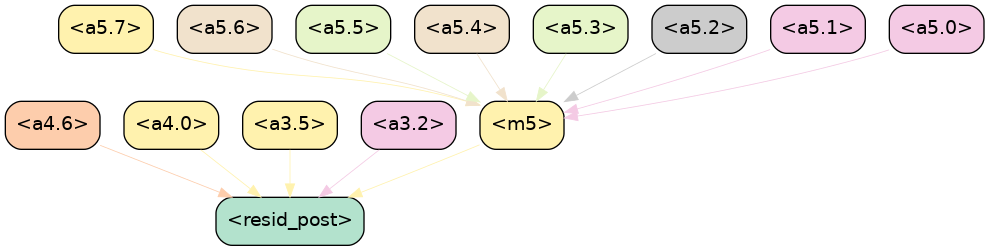

34 --------------------------------------------------
No edge 2503
2503
No edge 2503
New metric: 0.18705061078071594
No edge 2503
No edge 2503
No edge 2503
We moved to  blocks.4.attn.hook_result[:, :, 5]
No edge 2503
No edge 2503
But it's bad
We moved to  blocks.4.attn.hook_result[:, :, 4]
No edge 2503
No edge 2503
But it's bad
We moved to  blocks.4.attn.hook_result[:, :, 3]
No edge 2503
No edge 2503
But it's bad
We moved to  blocks.4.attn.hook_result[:, :, 2]
No edge 2503
No edge 2503
But it's bad
We moved to  blocks.4.attn.hook_result[:, :, 1]
No edge 2503
No edge 2503
But it's bad
We moved to  blocks.4.attn.hook_result[:, :, 0]
No edge 2503


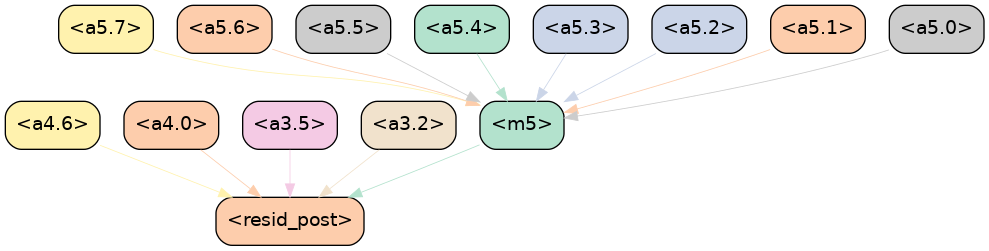

35 --------------------------------------------------
No edge 2503
2503
No edge 2503
New metric: 0.18705061078071594
No edge 2503
No edge 2503
No edge 2503
We moved to  blocks.4.attn.hook_v[:, :, 7]
No edge 2503
No edge 2502
But it's bad
We moved to  blocks.4.attn.hook_v[:, :, 6]
No edge 2502


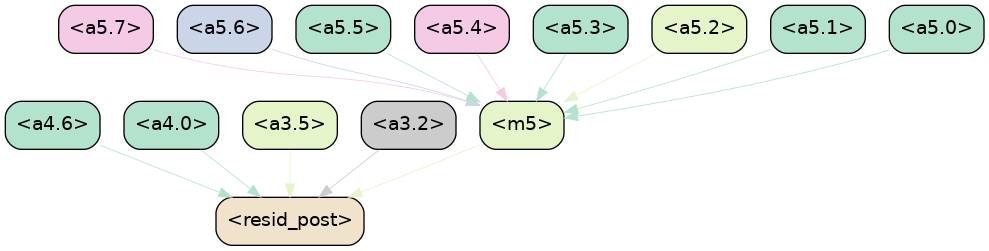

36 --------------------------------------------------
No edge 2502
2502
No edge 2502
New metric: 0.18705061078071594

Node: cur_parent=TLACDCInterpNode(blocks.4.hook_v_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.4.attn.hook_v, [:, :, 6]))

Metric after removing connection to blocks.4.hook_v_input [:, :, 6] is 0.26701438426971436 (and current metric 0.18705061078071594)
Result is 0.07996377348899841...so keeping connection
No edge 2502
We moved to  blocks.4.attn.hook_v[:, :, 5]
No edge 2502
No edge 2501
But it's bad
We moved to  blocks.4.attn.hook_v[:, :, 4]
No edge 2501
No edge 2500
But it's bad
We moved to  blocks.4.attn.hook_v[:, :, 3]
No edge 2500
No edge 2499
But it's bad
We moved to  blocks.4.attn.hook_v[:, :, 2]
No edge 2499
No edge 2498
But it's bad
We moved to  blocks.4.attn.hook_v[:, :, 1]
No edge 2498
No edge 2497
But it's bad
We moved to  blocks.4.attn.hook_v[:, :, 0]
No edge 2497


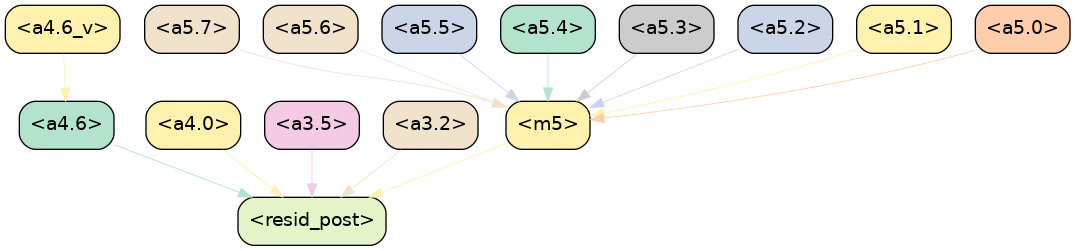

37 --------------------------------------------------
No edge 2497
2497
No edge 2497
New metric: 0.18705061078071594

Node: cur_parent=TLACDCInterpNode(blocks.4.hook_v_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.4.attn.hook_v, [:, :, 0]))

Metric after removing connection to blocks.4.hook_v_input [:, :, 0] is 0.23502697050571442 (and current metric 0.18705061078071594)
Result is 0.047976359724998474...so removing connection
No edge 2496
We moved to  blocks.4.attn.hook_k[:, :, 7]
No edge 2496
No edge 2495
But it's bad
We moved to  blocks.4.attn.hook_k[:, :, 6]
No edge 2495


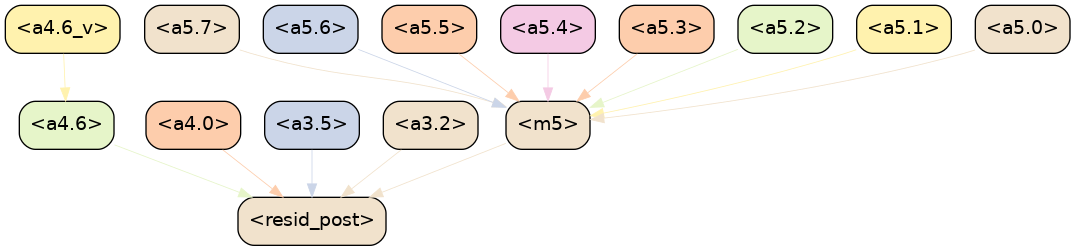

38 --------------------------------------------------
No edge 2495
2495
No edge 2495
New metric: 0.23502697050571442

Node: cur_parent=TLACDCInterpNode(blocks.4.hook_k_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.4.attn.hook_k, [:, :, 6]))

Metric after removing connection to blocks.4.hook_k_input [:, :, 6] is 0.24391019344329834 (and current metric 0.23502697050571442)
Result is 0.008883222937583923...so removing connection
No edge 2494
We moved to  blocks.4.attn.hook_k[:, :, 5]
No edge 2494
No edge 2493
But it's bad
We moved to  blocks.4.attn.hook_k[:, :, 4]
No edge 2493
No edge 2492
But it's bad
We moved to  blocks.4.attn.hook_k[:, :, 3]
No edge 2492
No edge 2491
But it's bad
We moved to  blocks.4.attn.hook_k[:, :, 2]
No edge 2491
No edge 2490
But it's bad
We moved to  blocks.4.attn.hook_k[:, :, 1]
No edge 2490
No edge 2489
But it's bad
We moved to  blocks.4.attn.hook_k[:, :, 0]
No edge 2489


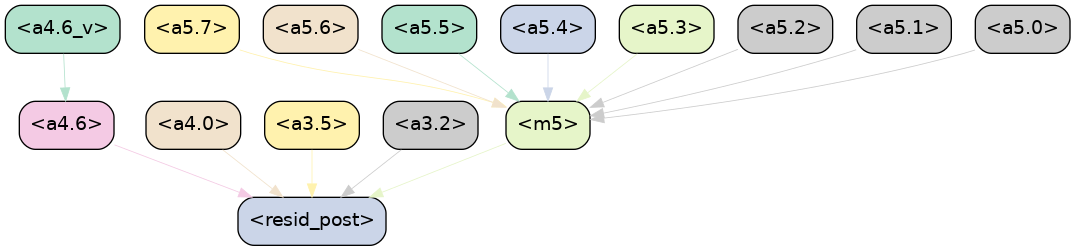

39 --------------------------------------------------
No edge 2489
2489
No edge 2489
New metric: 0.24391019344329834

Node: cur_parent=TLACDCInterpNode(blocks.4.hook_k_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.4.attn.hook_k, [:, :, 0]))

Metric after removing connection to blocks.4.hook_k_input [:, :, 0] is 0.24497739970684052 (and current metric 0.24391019344329834)
Result is 0.0010672062635421753...so removing connection
No edge 2488
We moved to  blocks.4.attn.hook_q[:, :, 7]
No edge 2488
No edge 2487
But it's bad
We moved to  blocks.4.attn.hook_q[:, :, 6]
No edge 2487


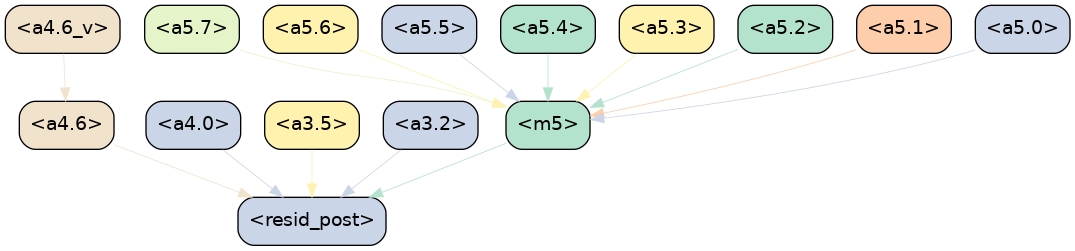

40 --------------------------------------------------
No edge 2487
2487
No edge 2487
New metric: 0.24497739970684052

Node: cur_parent=TLACDCInterpNode(blocks.4.hook_q_input, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.4.attn.hook_q, [:, :, 6]))

Metric after removing connection to blocks.4.hook_q_input [:, :, 6] is 0.24461181461811066 (and current metric 0.24497739970684052)
Result is -0.0003655850887298584...so removing connection
No edge 2486
We moved to  blocks.4.attn.hook_q[:, :, 5]
No edge 2486
No edge 2485
But it's bad
We moved to  blocks.4.attn.hook_q[:, :, 4]
No edge 2485
No edge 2484
But it's bad
We moved to  blocks.4.attn.hook_q[:, :, 3]
No edge 2484
No edge 2483
But it's bad
We moved to  blocks.4.attn.hook_q[:, :, 2]
No edge 2483
No edge 2482
But it's bad
We moved to  blocks.4.attn.hook_q[:, :, 1]
No edge 2482
No edge 2481
But it's bad
We moved to  blocks.4.attn.hook_q[:, :, 0]
No edge 2481


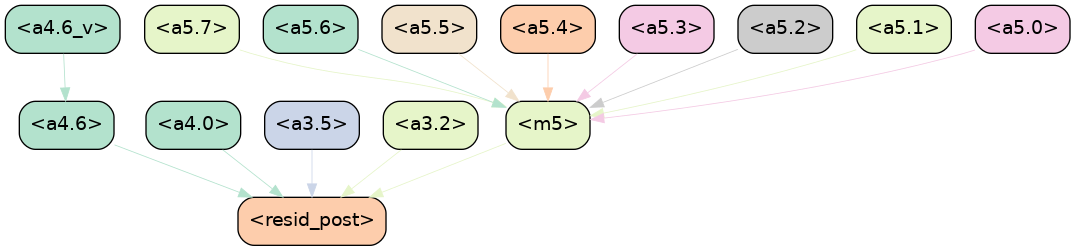

41 --------------------------------------------------
No edge 2481
2481
No edge 2481
New metric: 0.24461181461811066

Node: cur_parent=TLACDCInterpNode(blocks.4.hook_q_input, [:, :, 0]) (self.current_node=TLACDCInterpNode(blocks.4.attn.hook_q, [:, :, 0]))

Metric after removing connection to blocks.4.hook_q_input [:, :, 0] is 0.24444884061813354 (and current metric 0.24461181461811066)
Result is -0.00016297399997711182...so removing connection
No edge 2480
We moved to  blocks.4.hook_v_input[:, :, 7]
No edge 2480
No edge 2443
But it's bad
We moved to  blocks.4.hook_v_input[:, :, 6]
No edge 2443


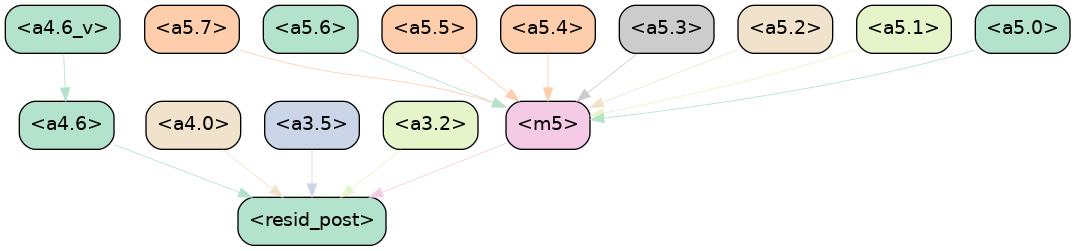

42 --------------------------------------------------
No edge 2443
2443
No edge 2443
New metric: 0.24444884061813354

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.4.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.3.hook_mlp_out [:] is 0.25230515003204346 (and current metric 0.24444884061813354)
Result is 0.007856309413909912...so removing connection
No edge 2442

Node: cur_parent=TLACDCInterpNode(blocks.3.attn.hook_result, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.4.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.3.attn.hook_result [:, :, 7] is 0.25231361389160156 (and current metric 0.25230515003204346)
Result is 8.463859558105469e-06...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.3.attn.hook_result, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.4.hook_v_input, [:, :, 6]))

Metric after removing connection to blocks.3.attn.hook_result [:, :, 6

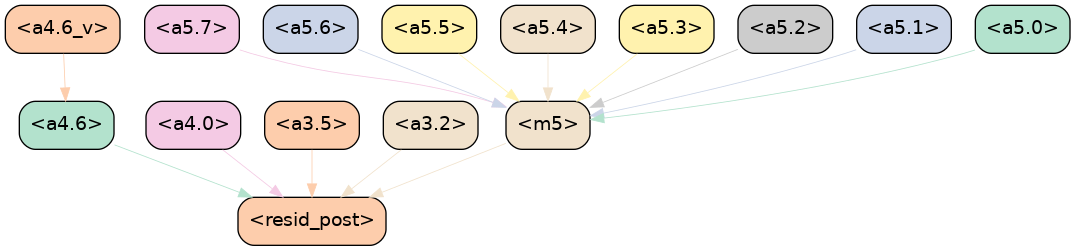

43 --------------------------------------------------
No edge 1556
1556
No edge 1556
New metric: 0.3357755243778229
No edge 1556
No edge 1556
No edge 1556
We moved to  blocks.3.attn.hook_result[:, :, 4]
No edge 1556
No edge 1556
But it's bad
We moved to  blocks.3.attn.hook_result[:, :, 3]
No edge 1556
No edge 1556
But it's bad
We moved to  blocks.3.attn.hook_result[:, :, 2]
No edge 1556


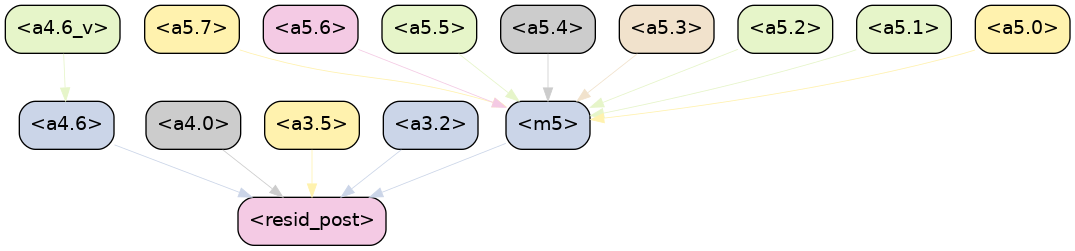

44 --------------------------------------------------
No edge 1556
1556
No edge 1556
New metric: 0.3357755243778229
No edge 1556
No edge 1556
No edge 1556
We moved to  blocks.3.attn.hook_result[:, :, 1]
No edge 1556
No edge 1556
But it's bad
We moved to  blocks.3.attn.hook_result[:, :, 0]
No edge 1556
No edge 1556
But it's bad
We moved to  blocks.3.attn.hook_v[:, :, 7]
No edge 1556
No edge 1555
But it's bad
We moved to  blocks.3.attn.hook_v[:, :, 6]
No edge 1555
No edge 1554
But it's bad
We moved to  blocks.3.attn.hook_v[:, :, 5]
No edge 1554


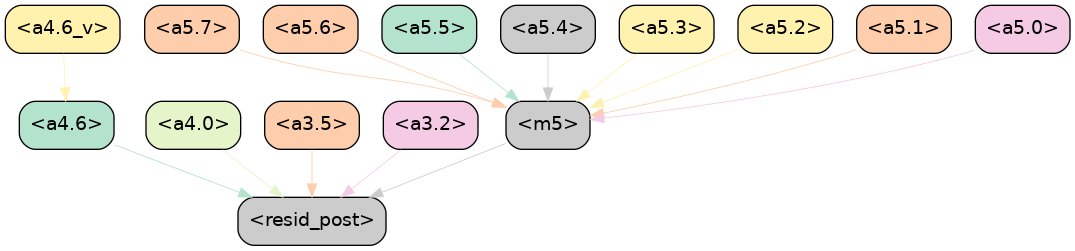

45 --------------------------------------------------
No edge 1554
1554
No edge 1554
New metric: 0.3357755243778229

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_v, [:, :, 5]))

Metric after removing connection to blocks.3.hook_v_input [:, :, 5] is 0.395866721868515 (and current metric 0.3357755243778229)
Result is 0.06009119749069214...so keeping connection
No edge 1554
We moved to  blocks.3.attn.hook_v[:, :, 4]
No edge 1554
No edge 1553
But it's bad
We moved to  blocks.3.attn.hook_v[:, :, 3]
No edge 1553
No edge 1552
But it's bad
We moved to  blocks.3.attn.hook_v[:, :, 2]
No edge 1552


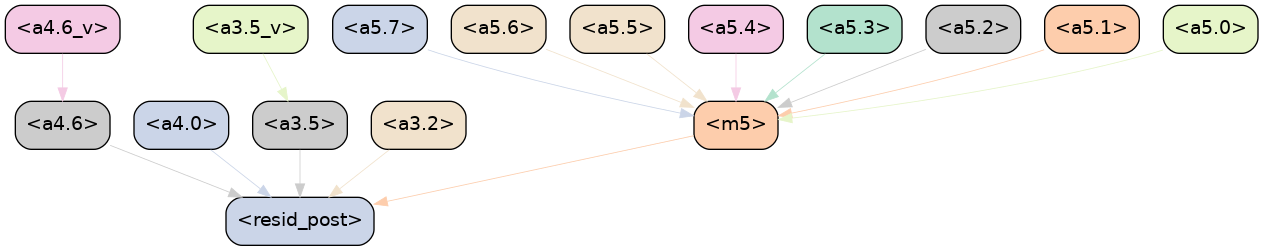

46 --------------------------------------------------
No edge 1552
1552
No edge 1552
New metric: 0.3357755243778229

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_v, [:, :, 2]))

Metric after removing connection to blocks.3.hook_v_input [:, :, 2] is 0.3722899556159973 (and current metric 0.3357755243778229)
Result is 0.03651443123817444...so removing connection
No edge 1551
We moved to  blocks.3.attn.hook_v[:, :, 1]
No edge 1551
No edge 1550
But it's bad
We moved to  blocks.3.attn.hook_v[:, :, 0]
No edge 1550
No edge 1549
But it's bad
We moved to  blocks.3.attn.hook_k[:, :, 7]
No edge 1549
No edge 1548
But it's bad
We moved to  blocks.3.attn.hook_k[:, :, 6]
No edge 1548
No edge 1547
But it's bad
We moved to  blocks.3.attn.hook_k[:, :, 5]
No edge 1547


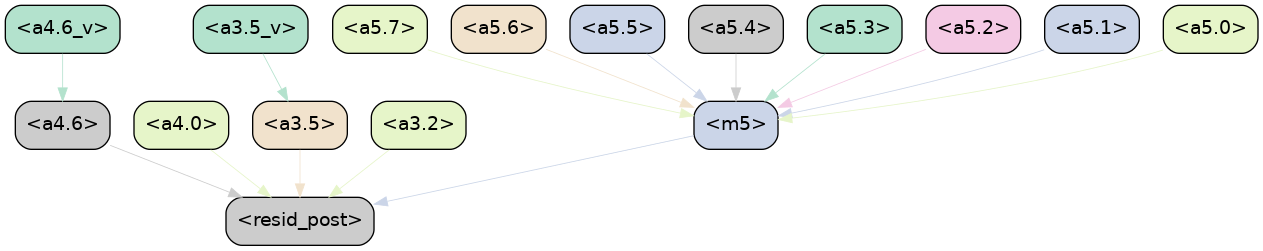

47 --------------------------------------------------
No edge 1547
1547
No edge 1547
New metric: 0.3722899556159973

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_k, [:, :, 5]))

Metric after removing connection to blocks.3.hook_k_input [:, :, 5] is 0.3755517601966858 (and current metric 0.3722899556159973)
Result is 0.0032618045806884766...so removing connection
No edge 1546
We moved to  blocks.3.attn.hook_k[:, :, 4]
No edge 1546
No edge 1545
But it's bad
We moved to  blocks.3.attn.hook_k[:, :, 3]
No edge 1545
No edge 1544
But it's bad
We moved to  blocks.3.attn.hook_k[:, :, 2]
No edge 1544


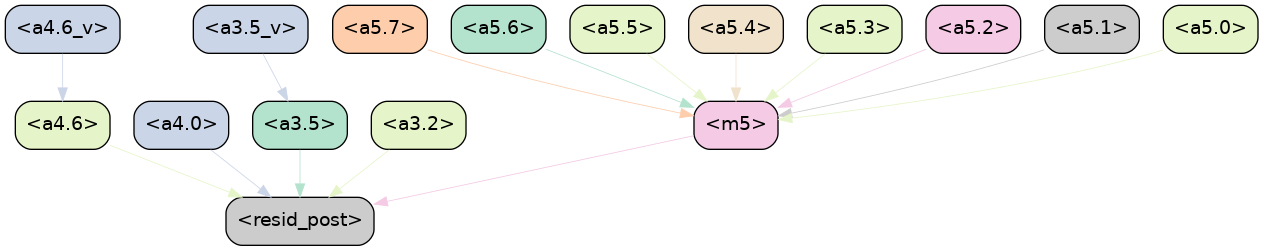

48 --------------------------------------------------
No edge 1544
1544
No edge 1544
New metric: 0.3755517601966858

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_k_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_k, [:, :, 2]))

Metric after removing connection to blocks.3.hook_k_input [:, :, 2] is 0.38006317615509033 (and current metric 0.3755517601966858)
Result is 0.004511415958404541...so removing connection
No edge 1543
We moved to  blocks.3.attn.hook_k[:, :, 1]
No edge 1543
No edge 1542
But it's bad
We moved to  blocks.3.attn.hook_k[:, :, 0]
No edge 1542
No edge 1541
But it's bad
We moved to  blocks.3.attn.hook_q[:, :, 7]
No edge 1541
No edge 1540
But it's bad
We moved to  blocks.3.attn.hook_q[:, :, 6]
No edge 1540
No edge 1539
But it's bad
We moved to  blocks.3.attn.hook_q[:, :, 5]
No edge 1539


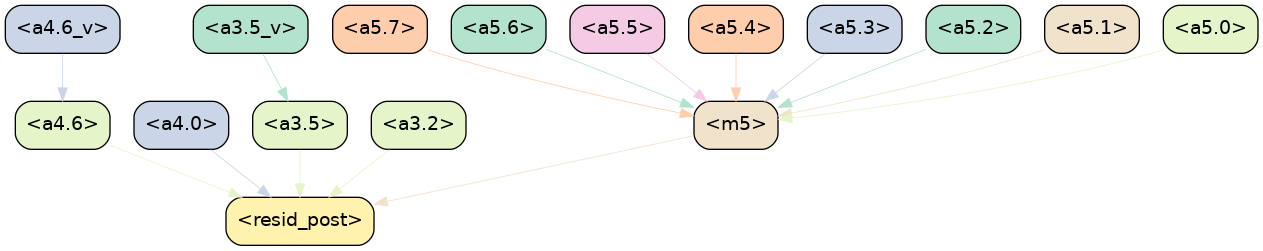

49 --------------------------------------------------
No edge 1539
1539
No edge 1539
New metric: 0.38006317615509033

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 5]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_q, [:, :, 5]))

Metric after removing connection to blocks.3.hook_q_input [:, :, 5] is 0.3808108866214752 (and current metric 0.38006317615509033)
Result is 0.0007477104663848877...so removing connection
No edge 1538
We moved to  blocks.3.attn.hook_q[:, :, 4]
No edge 1538
No edge 1537
But it's bad
We moved to  blocks.3.attn.hook_q[:, :, 3]
No edge 1537
No edge 1536
But it's bad
We moved to  blocks.3.attn.hook_q[:, :, 2]
No edge 1536


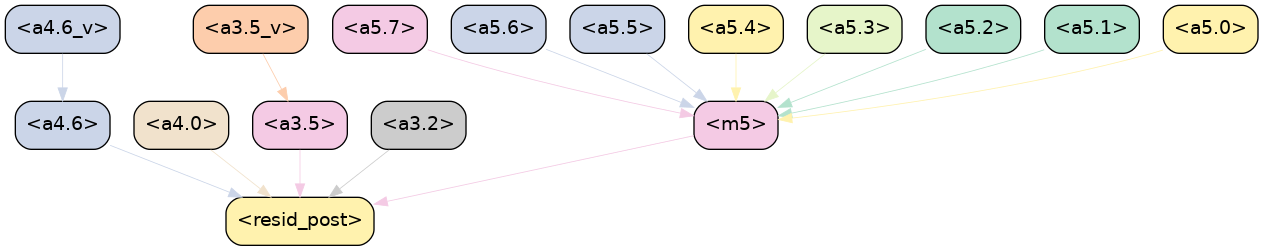

50 --------------------------------------------------
No edge 1536
1536
No edge 1536
New metric: 0.3808108866214752

Node: cur_parent=TLACDCInterpNode(blocks.3.hook_q_input, [:, :, 2]) (self.current_node=TLACDCInterpNode(blocks.3.attn.hook_q, [:, :, 2]))

Metric after removing connection to blocks.3.hook_q_input [:, :, 2] is 0.3796052932739258 (and current metric 0.3808108866214752)
Result is -0.0012055933475494385...so removing connection
No edge 1535
We moved to  blocks.3.attn.hook_q[:, :, 1]
No edge 1535
No edge 1534
But it's bad
We moved to  blocks.3.attn.hook_q[:, :, 0]
No edge 1534
No edge 1533
But it's bad
We moved to  blocks.3.hook_v_input[:, :, 7]
No edge 1533
No edge 1505
But it's bad
We moved to  blocks.3.hook_v_input[:, :, 6]
No edge 1505
No edge 1477
But it's bad
We moved to  blocks.3.hook_v_input[:, :, 5]
No edge 1477


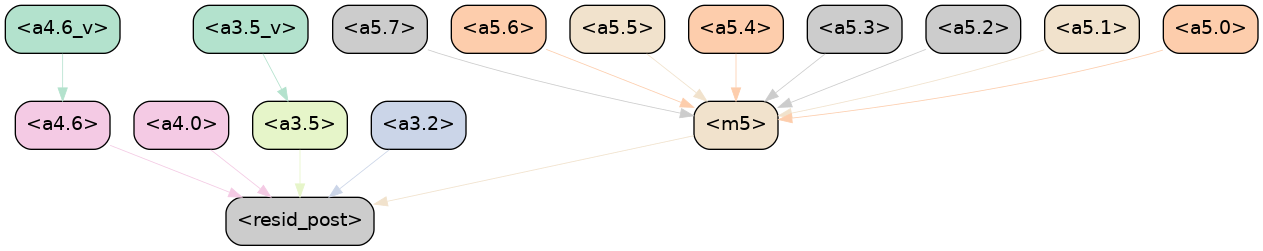

51 --------------------------------------------------
No edge 1477
1477
No edge 1477
New metric: 0.3796052932739258

Node: cur_parent=TLACDCInterpNode(blocks.2.hook_mlp_out, [:]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 5]))

Metric after removing connection to blocks.2.hook_mlp_out [:] is 0.3804980516433716 (and current metric 0.3796052932739258)
Result is 0.0008927583694458008...so removing connection
No edge 1476

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 7]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 5]))

Metric after removing connection to blocks.2.attn.hook_result [:, :, 7] is 0.38046011328697205 (and current metric 0.3804980516433716)
Result is -3.793835639953613e-05...so removing connection

Node: cur_parent=TLACDCInterpNode(blocks.2.attn.hook_result, [:, :, 6]) (self.current_node=TLACDCInterpNode(blocks.3.hook_v_input, [:, :, 5]))

Metric after removing connection to blocks.2.attn.hook_result [:, :, 6] 

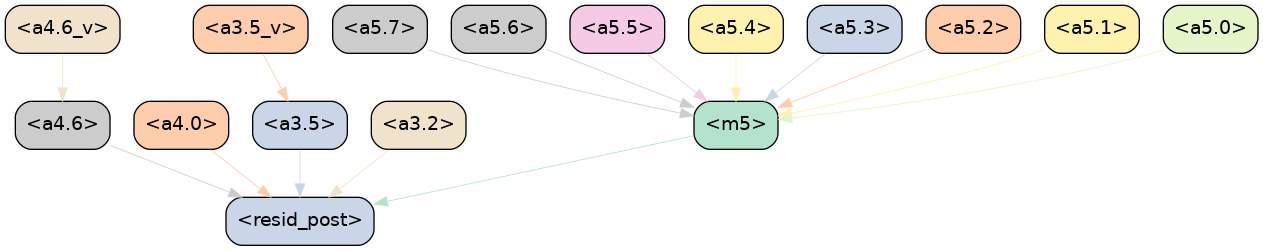

52 --------------------------------------------------
No edge 15
15
No edge 15
New metric: 0.4514814615249634
We moved to  None
No edge 15


/workspace/Automatic-Circuit-Discovery/acdc/TLACDCExperiment.py:772: UserWarning:

Finished iterating



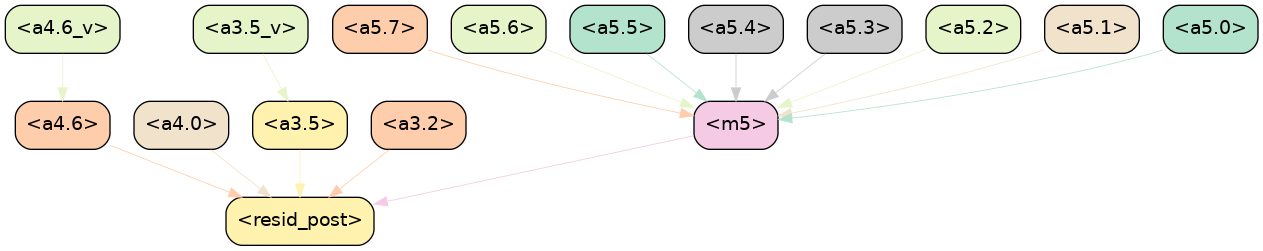

53 --------------------------------------------------
No edge 15
15


In [7]:
for i in range(args.max_num_epochs):
    exp.step(testing=False)

    show(
        exp.corr,
        f"ims/img_new_{i+1}.png",
        show_full_index=False,
    )

    if IN_COLAB or ipython is not None:
        # so long as we're not running this as a script, show the image!
        display(Image(f"ims/img_new_{i+1}.png"))

    print(i, "-" * 50)
    print(exp.count_no_edges())

    if i == 0:
        exp.save_edges("edges.pkl")

    if exp.current_node is None or SINGLE_STEP:
        break

exp.save_edges("another_final_edges.pkl")

if USING_WANDB:
    edges_fname = f"edges.pth"
    exp.save_edges(edges_fname)
    artifact = wandb.Artifact(edges_fname, type="dataset")
    artifact.add_file(edges_fname)
    wandb.log_artifact(artifact)
    os.remove(edges_fname)
    wandb.finish()

<h2>Save the final subgraph of the model</h2>
<p>There are more than `exp.count_no_edges()` here because we include some "placeholder" edges needed to make ACDC work that don't actually matter</p>
<p>Also note that the final image has more than 12 edges, because the edges from a0.0_q and a0.0_k are not connected to the input</p>
<p>We recover minimal induction machinery! `embed -> a0.0_v -> a1.6k`</p>

In [8]:
exp.save_subgraph(
    return_it=True,
)

OrderedDict([(('blocks.1.hook_resid_post',
               (None,),
               'blocks.1.attn.hook_result',
               (None, None, 6)),
              True),
             (('blocks.1.hook_resid_post',
               (None,),
               'blocks.0.hook_resid_pre',
               (None,)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_q',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_k',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_result',
               (None, None, 6),
               'blocks.1.attn.hook_v',
               (None, None, 6)),
              True),
             (('blocks.1.attn.hook_q',
               (None, None, 6),
               'blocks.1.hook_q_input',
               (None, None, 6)),
              True),
        